In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [277]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt

In [4]:
device = torch.device('cuda:0')
cfg = get_custom_cfg('bn_cnn_stack')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_030_loss_-2.77_pearson_0.6291_eval_loss_-29.18.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

In [5]:
test_data = DataLoader(TestDataset(cfg), batch_size=512)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 5, device, cfg)

In [69]:
with h5py.File('/home/TRAIN_DATA/15-10-07/naturalscene.h5', 'r') as f:
    target = f['test']['response']['firing_rate_10ms'][:5, 40:]
    single_trial = []
    for cell in ['cell01', 'cell02', 'cell03', 'cell04', 'cell05']:
        single_trial.append(f['test']['repeats'][cell])
    single_trial = np.stack(single_trial)
single_trial = np.swapaxes(single_trial,0,1)
single_trial = np.swapaxes(single_trial,1,2)[:,40:5996,:]
target = np.swapaxes(target,0,1)[:5956,:]

prediction correlation: 
 [[1.         0.41812848 0.73764551 0.38638577 0.27139948]
 [0.41812848 1.         0.61320255 0.50394363 0.25504505]
 [0.73764551 0.61320255 1.         0.40785126 0.32236908]
 [0.38638577 0.50394363 0.40785126 1.         0.28694018]
 [0.27139948 0.25504505 0.32236908 0.28694018 1.        ]]
trial-averaged correlation: 
 [[1.         0.1924971  0.51967268 0.29261007 0.21739408]
 [0.1924971  1.         0.29852532 0.27960452 0.14421011]
 [0.51967268 0.29852532 1.         0.24257533 0.2031594 ]
 [0.29261007 0.27960452 0.24257533 1.         0.2817152 ]
 [0.21739408 0.14421011 0.2031594  0.2817152  1.        ]]
single trial correlation: 
 [[1.         0.12576394 0.34438281 0.21857622 0.17052613]
 [0.12576394 1.         0.16655423 0.17993999 0.09052665]
 [0.34438281 0.16655423 1.         0.13613422 0.11973504]
 [0.21857622 0.17993999 0.13613422 1.         0.21250219]
 [0.17052613 0.09052665 0.11973504 0.21250219 1.        ]]
trial-averaged target prediction relative e

Text(0.5, 1.0, 'single trial target')

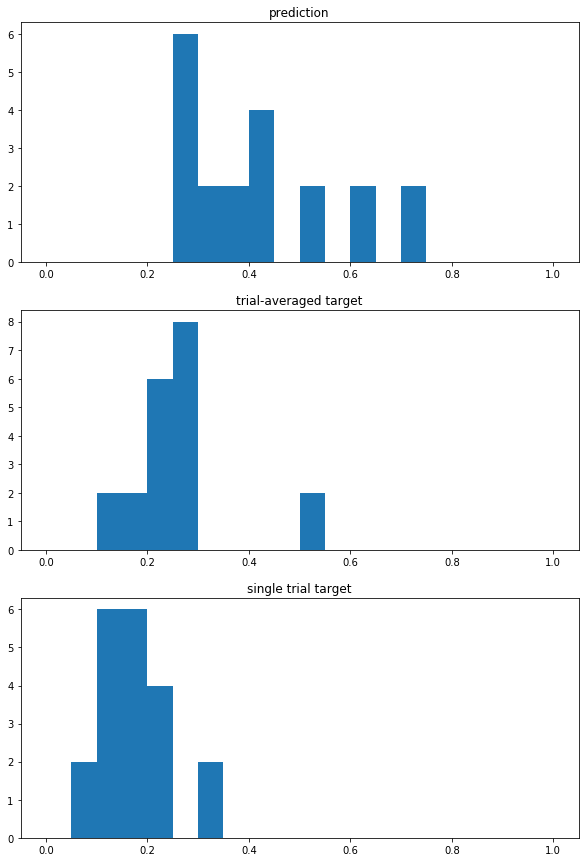

In [113]:
pred_corr, targ_corr, single_corr = correlation_matrix(pred, target, single_trial, binary=False)
print('prediction correlation: \n', pred_corr)
print('trial-averaged correlation: \n', targ_corr)
print('single trial correlation: \n', single_corr)
print('trial-averaged target prediction relative error: ', np.abs(targ_corr-pred_corr).sum()/targ_corr.sum())
print('single trial target prediction relative error: ', np.abs(single_corr-pred_corr).sum()/single_corr.sum())
fig,ax = plt.subplots(3,1,figsize=(10,15))
diagonal_idxs = [0, 6, 12, 18, 24]
ax[0].hist(np.delete(pred_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[0].set_title('prediction')
ax[1].hist(np.delete(targ_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[1].set_title('trial-averaged target')
ax[2].hist(np.delete(single_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[2].set_title('single trial target')

In [328]:
stim_corr = stimuli_corr_matrix(5, 5, single_trial)
noise_corr = single_corr - stim_corr
print('stimuli correlation: \n', stim_corr)
print('noise correlation: \n', noise_corr)
n_cells = 5
diagonal_idxs = list(range(0, n_cells*n_cells, n_cells+1))
mean_stim_corr = np.delete(stim_corr.flatten(), diagonal_idxs).mean()
mean_noise_corr = np.delete(noise_corr.flatten(), diagonal_idxs).mean()
print(mean_stim_corr, mean_noise_corr)

stimuli correlation: 
 [[0.67177597 0.11595256 0.2977213  0.22079329 0.15485661]
 [0.11595256 0.35368846 0.13764053 0.16512185 0.08163705]
 [0.2977213  0.13764053 0.34117301 0.14615804 0.1148277 ]
 [0.22079329 0.16512185 0.14615804 0.68809142 0.20296255]
 [0.15485661 0.08163705 0.1148277  0.20296255 0.61850253]]
noise correlation: 
 [[ 0.32822403  0.00981137  0.04666152 -0.00221707  0.01566952]
 [ 0.00981137  0.64631154  0.0289137   0.01481814  0.0088896 ]
 [ 0.04666152  0.0289137   0.65882699 -0.01002382  0.00490734]
 [-0.00221707  0.01481814 -0.01002382  0.31190858  0.00953964]
 [ 0.01566952  0.0088896   0.00490734  0.00953964  0.38149747]]
0.16376714910437626 0.012696993584019984


In [248]:
Fano(single_trial)

0.09103926791651518

prediction correlation: 
 [[ 1.         -0.00835926  0.00676478  0.02139853  0.02643943]
 [-0.00835926  1.         -0.00703164  0.00452798  0.01574806]
 [ 0.00676478 -0.00703164  1.          0.02921365 -0.00737698]
 [ 0.02139853  0.00452798  0.02921365  1.          0.01888876]
 [ 0.02643943  0.01574806 -0.00737698  0.01888876  1.        ]]
trial-averaged correlation: 
 [[1.         0.1924971  0.51967268 0.29261007 0.21739408]
 [0.1924971  1.         0.29852532 0.27960452 0.14421011]
 [0.51967268 0.29852532 1.         0.24257533 0.2031594 ]
 [0.29261007 0.27960452 0.24257533 1.         0.2817152 ]
 [0.21739408 0.14421011 0.2031594  0.2817152  1.        ]]
single trial correlation: 
 [[1.         0.12576394 0.34438281 0.21857622 0.17052613]
 [0.12576394 1.         0.16655423 0.17993999 0.09052665]
 [0.34438281 0.16655423 1.         0.13613422 0.11973504]
 [0.21857622 0.17993999 0.13613422 1.         0.21250219]
 [0.17052613 0.09052665 0.11973504 0.21250219 1.        ]]
trial-averaged tar

Text(0.5, 1.0, 'single trial target')

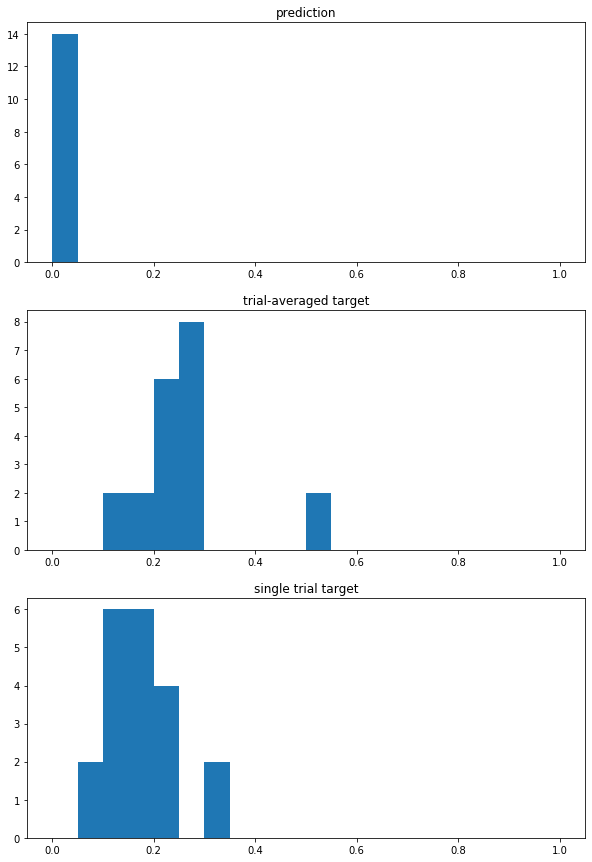

In [127]:
with torch.no_grad():
    val_pred = []
    val_targ = []
    for x,y in test_data:
        x = x.to(device)
        out = model.bipolar(x)
        out = model.amacrine(out)
        out = 100*torch.poisson(0.01*model.ganglion(out))
        val_pred.append(out.detach().cpu().numpy())
        val_targ.append(y.detach().numpy())
    val_pred = np.concatenate(val_pred, axis=0)
    val_targ = np.concatenate(val_targ, axis=0)
#pred_corr, targ_corr = correlation_matrix(val_pred, val_targ, binary=True, thre=2)
pred_corr, targ_corr, single_corr = correlation_matrix(val_pred, target, single_trial, binary=False)
print('prediction correlation: \n', pred_corr)
print('trial-averaged correlation: \n', targ_corr)
print('single trial correlation: \n', single_corr)
print('trial-averaged target prediction relative error: ', np.abs(targ_corr-pred_corr).sum()/targ_corr.sum())
print('single trial target prediction relative error: ', np.abs(single_corr-pred_corr).sum()/single_corr.sum())
fig,ax = plt.subplots(3,1,figsize=(10,15))
diagonal_idxs = [0, 6, 12, 18, 24]
ax[0].hist(np.delete(pred_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[0].set_title('prediction')
ax[1].hist(np.delete(targ_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[1].set_title('trial-averaged target')
ax[2].hist(np.delete(single_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[2].set_title('single trial target')

In [128]:
pearsons = []
for cell in range(5):
    pearsons.append(pearsonr(val_pred[:,cell],target[:,cell])[0])
print('trial-averged vs prediction:', np.array(pearsons).mean())
mean_r = []
for trial in range(5):
    pearsons = []
    for cell in range(5):
        pearsons.append(pearsonr(single_trial[trial,:,cell],target[:,cell])[0])
    mean_r.append(np.array(pearsons).mean())
print('trial-averged vs single-trial:', np.array(mean_r).mean())
mean_r = []
for trial in range(5):
    pearsons = []
    for cell in range(5):
        pearsons.append(pearsonr(single_trial[trial,:,cell],val_pred[:,cell])[0])
    mean_r.append(np.array(pearsons).mean())
print('single-trial vs prediction:', np.array(mean_r).mean())

trial-averged vs prediction: 0.10045079837291668
trial-averged vs single-trial: 0.7875977724261742
single-trial vs prediction: 0.08025481102764315


0.01 0.10568852933252204 0.18683400844175896 0.1693569 0.038779577961001885 0.12281409089120687
0.1 0.1180022328124093 0.3051612272870253 0.04561581 0.0551584787230749 0.07098194291366115
0.2 0.10344957623009497 0.36674433057600864 0.030399218 0.07158239660818219 0.0608010992173007
0.3 0.07847632817810878 0.4312581184147186 0.023952793 0.08672592705691132 0.06177984484649972
0.4 0.07546279304912076 0.4674001434514839 0.019793475 0.10561460060176187 0.0539027936754972
0.5 0.07302495872323544 0.5027409901943625 0.017409032 0.1154739985593298 0.061572804330215204
0.6 0.10177852164489312 0.5283867526738497 0.015349437 0.13945442051366674 0.050729729079199995
0.7 0.10077910294302127 0.5505973955441814 0.0139300255 0.14860920177918352 0.04957275718173586
0.8 0.11498587070117414 0.5696450313321189 0.012647073 0.1616872104332051 0.049389019960075574
0.9 0.13189154457832183 0.5816327460820374 0.011609024 0.17312024455209543 0.04650634397838436
1.0 0.14296437304549636 0.593509946702307 0.0108722

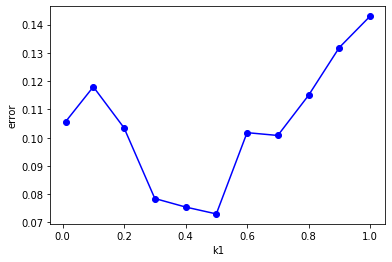

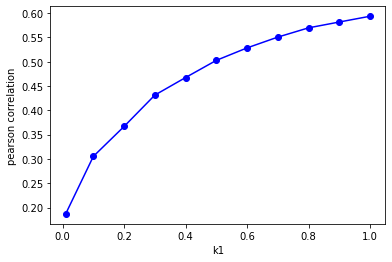

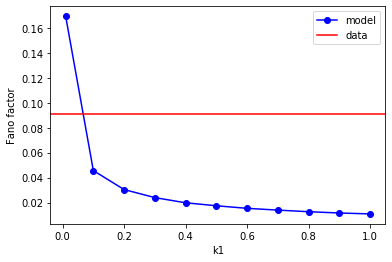

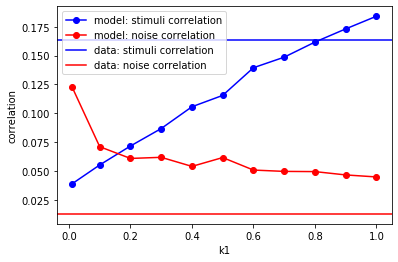

In [335]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
k1_list = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
for k1 in k1_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr = Noises(model, test_data, single_corr, device, poisson=[k1, None, None])
    print(k1, error, accuracy, fano, mean_stim_corr, mean_noise_corr)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
single_noise_plot('k1', k1_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list)

0.01 0.3834876802687916 0.3021331275866861 0.80347687 0.013917096858125316 -0.000996698967120569
0.05 0.2798521325952597 0.5137543839343202 0.15926826 0.05630175364217925 0.0008154892394606504
0.1 0.18164356233462267 0.5841500188069082 0.079586245 0.1054659451526621 -0.00646626855016671
0.2 0.11941147742048033 0.6407165434128499 0.03997557 0.17394054397570843 -0.0024248140308513453
0.3 0.13938815678176764 0.6797296193195267 0.0266593 0.21104746733586857 0.002116588692954082
0.4 0.17605108116585325 0.6887318588176925 0.019947372 0.24234395844699436 -0.0009386348964237886
0.5 0.2229586030689273 0.7022352232734682 0.015987463 0.2661938854887226 7.91518077518788e-05


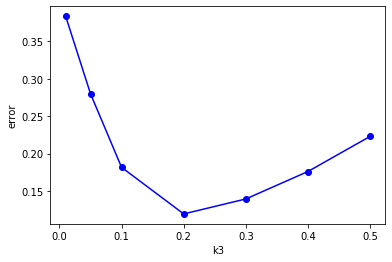

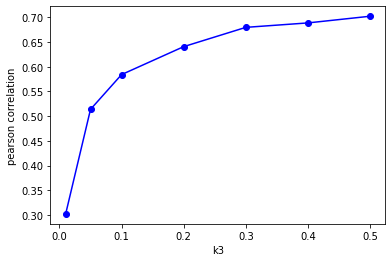

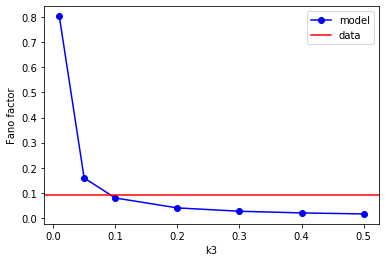

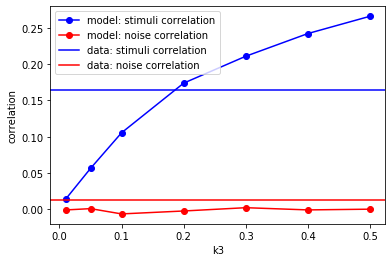

In [336]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
k3_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
for k3 in k3_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr = Noises(model, test_data, single_corr, device, poisson=[None, None, k3])
    print(k3, error, accuracy, fano, mean_stim_corr, mean_noise_corr)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
single_noise_plot('k3', k3_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list)

0.01 0.12907670602921523 0.16822844997901568 0.18281627 0.021183670105943294 0.1444846202588293
0.1 0.16950089536977464 0.3476793508272461 0.059011266 0.03764389376542617 0.07586057286964894
0.2 0.1334170468501288 0.4417385695763196 0.041223437 0.06543731912578793 0.062220756499952
0.3 0.11300402286409197 0.49624667504861497 0.032593053 0.07936937733319746 0.06060199143600535
0.4 0.088337938754378 0.5345947124828699 0.027769333 0.10297419512443098 0.058446132439988564
0.5 0.08036433030816692 0.5673876040126586 0.024228748 0.11873733515375351 0.056249265033877116
0.6 0.09714510072910283 0.5948840523862973 0.021643085 0.14386106738590826 0.051102380600684935
0.7 0.11088367307732679 0.6071945132209798 0.01951521 0.15447294562870537 0.04845787253434846
0.8 0.1293024106923954 0.6186027312607262 0.018025333 0.16402325841722343 0.04741551182673446
0.9 0.11823990834276986 0.6281836698817267 0.016444333 0.1708981197294664 0.04441605336960901
1.0 0.14425108188875452 0.6395742544397117 0.01529606

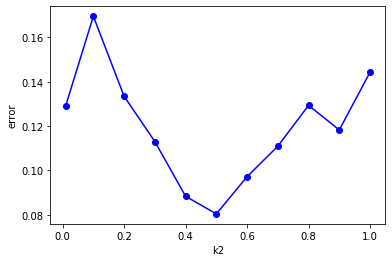

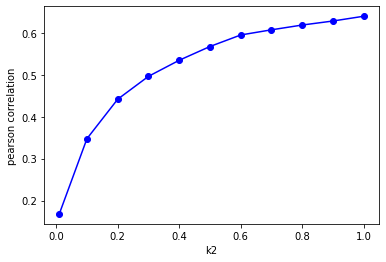

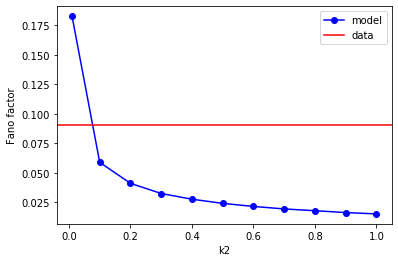

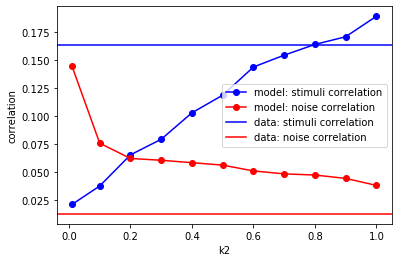

In [337]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
k2_list = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
for k2 in k2_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr = Noises(model, test_data, single_corr, device, poisson=[None, k2, None])
    print(k2, error, accuracy, fano, mean_stim_corr, mean_noise_corr)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
single_noise_plot('k2', k2_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list)

0.0 0.5717408143603652 0.7377298736784341 5.3039813e-18 0.42029109892455424 4.4408920985006264e-17
0.1 0.5202510596876261 0.7275063742771863 0.0013904201 0.39401804282088426 0.004314522019924559
0.2 0.34815587603893816 0.6963882752819224 0.005096139 0.3095436249442753 0.015396514940993733
0.3 0.17077149854053 0.6365915067945187 0.009649825 0.20437577905137067 0.0310673640226286
0.4 0.09077210739703412 0.5600866810171495 0.014402419 0.12811025113363433 0.03744435253888044
0.5 0.14029743878170522 0.4900466793046364 0.019150542 0.07301206477964642 0.04435546017693084
0.6 0.19591027516597015 0.41624678830495954 0.023461435 0.04926482256253066 0.043650612583362836
0.7 0.23916319252294188 0.36189534589005634 0.02803841 0.030845600360081944 0.04362401646639854
0.8 0.26059252092358753 0.30551775728855024 0.032166272 0.021673817048456452 0.04365695961325461
1.0 0.28239422686473575 0.21817178824592937 0.039905027 0.012220581091474562 0.0438125497369002
1.5 0.2871191131185588 0.13657218044720087 

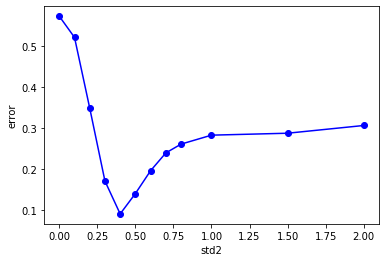

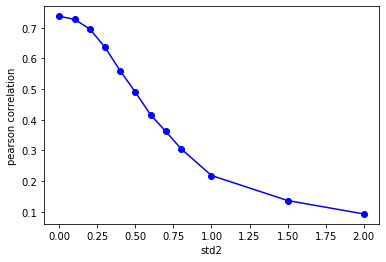

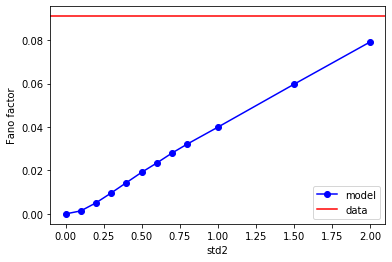

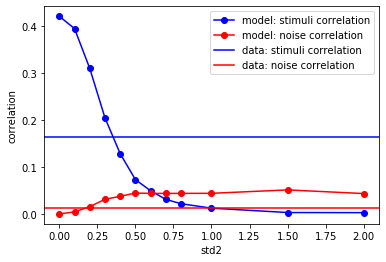

In [338]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
std2_list = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.5, 2.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
for std2 in std2_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr = Noises(model, test_data, single_corr, device, gaussian=[0, 0, std2, 0])
    print(std2, error, accuracy, fano, mean_stim_corr, mean_noise_corr)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
single_noise_plot('std2', std2_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list)

0.0 0.5717408143603652 0.7377298736784341 5.3039813e-18 0.42029109892455424 4.4408920985006264e-17
0.1 0.5640821448390385 0.7243443731693431 0.0011395863 0.41156239787984517 0.005462553113162816
0.2 0.35535909238300306 0.6611107793486981 0.0046603465 0.2989280669806724 0.025115220202825684
0.3 0.1783495392123248 0.5586453770280803 0.009047562 0.17095495139453523 0.04923221529132635
0.4 0.12198857495196497 0.4536940632938613 0.013530373 0.09223211933278871 0.06496423303996345
0.5 0.1377501246341747 0.3566827326510457 0.018279256 0.05115637544216123 0.07277876218879654
0.6 0.16914663473266542 0.2814679277820053 0.022673301 0.03190928947730412 0.07448358695731676
0.7 0.1981688723151428 0.21967339438003006 0.027131775 0.017597039080418986 0.07435518536857412
0.8 0.20976295611977427 0.16945837529926486 0.03165688 0.009381542860367966 0.07762622057862557
1.0 0.21223780410957035 0.11482877365427287 0.040046986 0.006552191507451353 0.07940013800528971
1.5 0.2310489516082907 0.04348314433904973

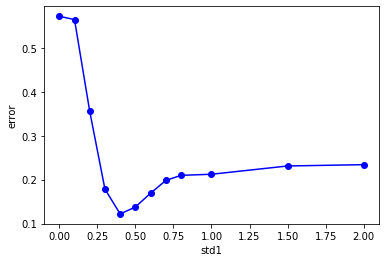

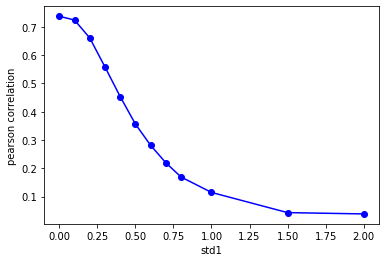

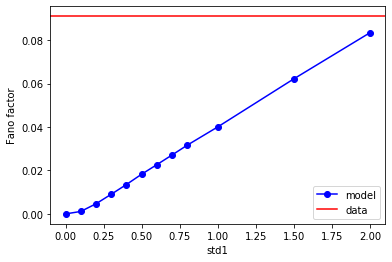

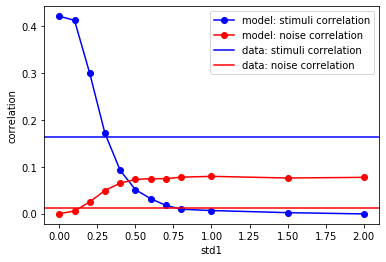

In [339]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
std1_list = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.5, 2.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
for std1 in std1_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr = Noises(model, test_data, single_corr, device, gaussian=[0, std1, 0, 0])
    print(std1, error, accuracy, fano, mean_stim_corr, mean_noise_corr)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
single_noise_plot('std1', std1_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list)

2.0 0.5717408143603652 0.7377298736784341 5.3039813e-18 0.42029109892455424 4.4408920985006264e-17
2.0 0.5715490347283355 0.7376793036239472 1.7727018e-05 0.42020792611587654 1.3856723191874033e-06
2.0 0.5693361030466183 0.7378057396365933 7.048251e-05 0.4192599420951785 5.6336805456747016e-06
2.0 0.5658546897421994 0.7371752391401982 0.00015900834 0.41774578577488386 3.50920606273536e-05
2.0 0.5612464644863152 0.7367924017427405 0.0002803645 0.4158192970976159 -3.662095170373081e-06
2.0 0.5547642034027844 0.7369684127177777 0.00044080647 0.41311562986428374 -6.444677750860605e-05
2.0 0.5485266905430387 0.735831562728025 0.0006321657 0.41045426380275174 -6.315629021588637e-05
2.0 0.5392230102529311 0.7344302989974076 0.00085950276 0.4064086716962608 1.474977750739459e-05
2.0 0.529433247431605 0.7339830265779432 0.0011065734 0.40208917657850324 0.00015926208654539476
2.0 0.5068062380853428 0.7334847865470192 0.0017088413 0.39254620229630366 5.26282262889588e-05
2.0 0.42326632962880684 0

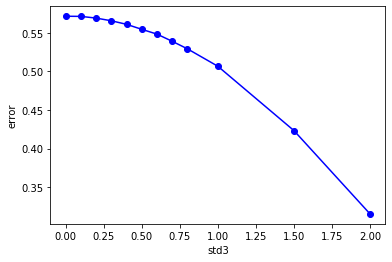

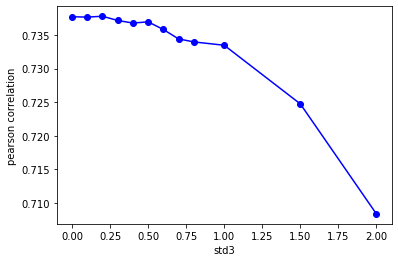

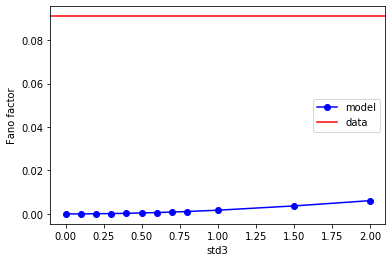

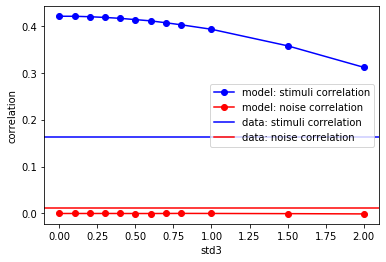

In [340]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
std3_list = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.5, 2.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
for std3 in std3_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr = Noises(model, test_data, single_corr, device, gaussian=[0, 0, 0, std3])
    print(std1, error, accuracy, fano, mean_stim_corr, mean_noise_corr)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
single_noise_plot('std3', std3_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list)

prediction correlation: 
 [[1.         0.09193404 0.24350074 0.09368775 0.04254497]
 [0.09193404 1.         0.14045836 0.09550816 0.03778656]
 [0.24350074 0.14045836 1.         0.08991315 0.04446602]
 [0.09368775 0.09550816 0.08991315 1.         0.10632073]
 [0.04254497 0.03778656 0.04446602 0.10632073 1.        ]]
trial-averaged correlation: 
 [[1.         0.1924971  0.51967268 0.29261007 0.21739408]
 [0.1924971  1.         0.29852532 0.27960452 0.14421011]
 [0.51967268 0.29852532 1.         0.24257533 0.2031594 ]
 [0.29261007 0.27960452 0.24257533 1.         0.2817152 ]
 [0.21739408 0.14421011 0.2031594  0.2817152  1.        ]]
single trial correlation: 
 [[1.         0.12576394 0.34438281 0.21857622 0.17052613]
 [0.12576394 1.         0.16655423 0.17993999 0.09052665]
 [0.34438281 0.16655423 1.         0.13613422 0.11973504]
 [0.21857622 0.17993999 0.13613422 1.         0.21250219]
 [0.17052613 0.09052665 0.11973504 0.21250219 1.        ]]
trial-averaged target prediction relative e

Text(0.5, 1.0, 'single trial target')

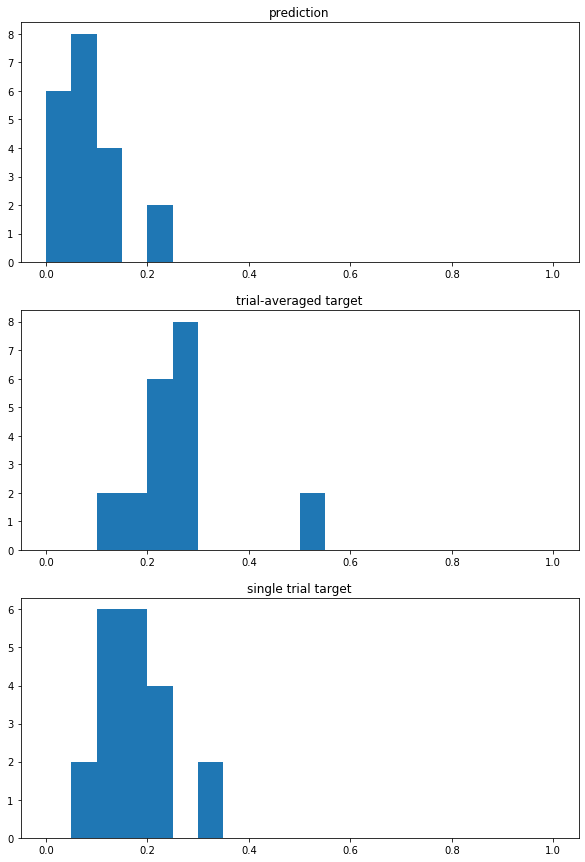

In [115]:
with torch.no_grad():
    val_pred = []
    val_targ = []
    for x,y in test_data:
        x = x.to(device)
        out = torch.poisson(model.bipolar(x))
        out = torch.poisson(model.amacrine(out))
        out = torch.poisson(model.ganglion(out))
        val_pred.append(out.detach().cpu().numpy())
        val_targ.append(y.detach().numpy())
    val_pred = np.concatenate(val_pred, axis=0)
    val_targ = np.concatenate(val_targ, axis=0)
#pred_corr, targ_corr = correlation_matrix(val_pred, val_targ, binary=True, thre=2)
pred_corr, targ_corr, single_corr = correlation_matrix(val_pred, target, single_trial, binary=False)
print('prediction correlation: \n', pred_corr)
print('trial-averaged correlation: \n', targ_corr)
print('single trial correlation: \n', single_corr)
print('trial-averaged target prediction relative error: ', np.abs(targ_corr-pred_corr).sum()/targ_corr.sum())
print('single trial target prediction relative error: ', np.abs(single_corr-pred_corr).sum()/single_corr.sum())
fig,ax = plt.subplots(3,1,figsize=(10,15))
diagonal_idxs = [0, 6, 12, 18, 24]
ax[0].hist(np.delete(pred_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[0].set_title('prediction')
ax[1].hist(np.delete(targ_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[1].set_title('trial-averaged target')
ax[2].hist(np.delete(single_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[2].set_title('single trial target')

In [123]:
pearsons = []
for cell in range(5):
    pearsons.append(pearsonr(val_pred[:,cell],target[:,cell])[0])
print('trial-averged vs prediction:', np.array(pearsons).mean())

trial-averged vs prediction: 0.21228164087716733


In [125]:
mean_r = []
for trial in range(5):
    pearsons = []
    for cell in range(5):
        pearsons.append(pearsonr(single_trial[trial,:,cell],target[:,cell])[0])
    mean_r.append(np.array(pearsons).mean())
print('trial-averged vs single-trial:', np.array(mean_r).mean())

trial-averged vs single-trial: 0.7875977724261742


In [126]:
mean_r = []
for trial in range(5):
    pearsons = []
    for cell in range(5):
        pearsons.append(pearsonr(single_trial[trial,:,cell],val_pred[:,cell])[0])
    mean_r.append(np.array(pearsons).mean())
print('single-trial vs prediction:', np.array(mean_r).mean())

single-trial vs prediction: 0.1720378012537985


In [322]:
from utils import noise_model
n_cells = 5
n_repeats = 5
with torch.no_grad():
    pred_corr = []
    pred_single_trial = []
    for n in range(n_repeats):
        val_pred = []
        val_targ = []
        for x,y in test_data:
            x = x.to(device)
            out = noise_model(x, model, device, poisson=[0.8, None, None])
            val_pred.append(out.detach().cpu().numpy())
            val_targ.append(y.detach().numpy())
        val_pred = np.concatenate(val_pred, axis=0)
        val_targ = np.concatenate(val_targ, axis=0)
        pred_corr.append(corr_matrix(n_cells, val_pred))
        pred_single_trial.append(val_pred)
    pred_corr = np.stack(pred_corr).mean(axis=0)
    pred_single_trial = np.stack(pred_single_trial)
error = np.abs(single_corr-pred_corr).sum()/single_corr.sum()
pearsons = []
pred_mean = pred_single_trial.mean(axis=0)
for cell in range(n_cells):
    pearsons.append(pearsonr(pred_mean[:,cell],val_targ[:,cell])[0])
accuracy = np.array(pearsons).mean()
fano = Fano(pred_single_trial)
stim_corr = stimuli_corr_matrix(n_cells, n_repeats, pred_single_trial)
noise_corr = pred_corr - stim_corr

In [ ]:
diagonal_idxs = list(range(0, n_cells*n_cells, n_cells+1))
mean_stim_corr = np.delete(stim_corr.flatten(), diagonal_idxs).mean()
mean_noise_corr = np.delete(noise_corr.flatten(), diagonal_idxs).mean()

In [324]:
pred_corr.mean()

0.36704297135493147

In [325]:
single_corr.mean()

0.34117131415071666

In [326]:
stim_corr.mean(), noise_corr.mean()

(0.19488913411905132, 0.17215383723588015)

In [327]:
single_corr

array([[1.        , 0.12576394, 0.34438281, 0.21857622, 0.17052613],
       [0.12576394, 1.        , 0.16655423, 0.17993999, 0.09052665],
       [0.34438281, 0.16655423, 1.        , 0.13613422, 0.11973504],
       [0.21857622, 0.17993999, 0.13613422, 1.        , 0.21250219],
       [0.17052613, 0.09052665, 0.11973504, 0.21250219, 1.        ]])